### Импорты для Текста!

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from navec import Navec
import re

### Общие импорты

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

## Импорты для сети

In [3]:
from keras.models import Sequential, Input, load_model
from keras.layers import Dense, LSTM, SpatialDropout1D
from random import sample

Using TensorFlow backend.


### Импорты для ресерча!

In [3]:
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Настройка работы с текстом (загрузка)

In [4]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

In [5]:
navec = Navec.load(path)

# Пример текста

In [7]:
profile = "Я хочу быть дизайнером, но получается программистом, возьмите на работу пожалуйста"

Токенизируем

In [8]:
token = word_tokenize(''.join( c for c in re.sub(r'\b\w{1,3}\b', '', profile) if  c not in '.,!()-:?' ))

In [9]:
token

['хочу',
 'быть',
 'дизайнером',
 'получается',
 'программистом',
 'возьмите',
 'работу',
 'пожалуйста']

# Русский Word2vec

In [10]:
token_vectors = np.array([navec[x] for x in token])

In [11]:
print(token_vectors.shape)

(8, 300)


# Грузим данные из твиттов, на них поучимся

In [10]:
positive = pd.read_csv("train_data/positive.csv", delimiter=";", index_col=False)
negative = pd.read_csv("train_data/negative.csv", delimiter=";", index_col=False)
positive['ttext'] = positive['ttext'].apply(lambda x: x.lower())
positive['ttext'] = positive['ttext'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
negative['ttext'] = negative['ttext'].apply(lambda x: x.lower())
negative['ttext'] = negative['ttext'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [11]:
negative

,id,tdate,tmane,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,d,-1,0,0,0,8064,111,94
1,408906818262687744,1386325957,nugemycejela,urban terror,-1,0,0,0,26,42,39
2,408906858515398656,1386325966,4post21,elina_4post,-1,0,0,0,718,49,249
3,408906914437685248,1386325980,Poliwake,httptcojclnzvnv3s,-1,0,0,0,10628,207,200
4,408906914723295232,1386325980,capyvixowe,surf,-1,0,0,0,35,17,34
...,...,...,...,...,...,...,...,...,...,...,...
111918,425138243257253888,1390195830,Yanch_96,httptcoqnoddqzuz7,-1,0,0,0,1138,32,46
111919,425138339503943682,1390195853,tkit_on,taaannyaaa,-1,0,0,0,4822,38,32
111920,425138437684215808,1390195876,ckooker1,,-1,0,0,1,165,13,16
111921,425138490452344832,1390195889,LisaBeroud,rt _them__ lisaberoud,-1,0,1,0,2516,187,265


# Готовим обучающую и тестовую выборку

In [24]:
X = np.hstack([positive["ttext"].values[:50000] , negative["ttext"].values[:50000]])
y = (np.hstack([positive["ttype"].values[:50000] , negative["ttype"].values[:50000]]) + 1) / 2
y = np.eye(2)[y.reshape(-1).astype(np.int8)]

In [26]:
print(X.shape, y.shape, X.shape == y.shape)

(100000,) (100000, 2) False


In [24]:
def vectorizator(X:np.array, max_lenth=None, verbose=False):
    tokens = []
    if max_lenth == None:
        max_lenth = 0
        flag_to_compute = True
    else:
        flag_to_compute = False
        
    for i in X:
        tokens.append(word_tokenize(''.join( c for c in re.sub(r'', '', i) if  c not in '.,!()-:?' )))
        if flag_to_compute == True and len(tokens[-1]) > max_lenth:
            max_lenth = len(tokens[-1])
    
    if verbose:
        print(f"Максимальная длинна сообщения: {max_lenth}")
    
    for i in range(len(tokens)):
        tokens[i].extend([0 for x in range(max_lenth - len(tokens[i]))])
    
    vec = np.ndarray(shape=(len(X), max_lenth, 300))
    
    for phrase in range(len(tokens)):
        for word in range(len(tokens[phrase])):
            if tokens[phrase][word] == 0:
                vec[phrase, word] = np.zeros(shape = (1, 300))
            else:
                try :
                    vec[phrase, word] = navec[tokens[phrase][word].lower()]
                except KeyError:
                    vec[phrase, word] = np.zeros(shape = (1, 300))
    
    return vec

In [27]:
X = vectorizator(X, None)

Максимальная длинна сообщения: 18


In [25]:
np.save("/home/gpu/DataDrive/TempData/X", X)
np.save("/home/gpu/DataDrive/TempData/y", y)

# LSTM go brrrrr

In [7]:
X = np.load("/home/gpu/DataDrive/TempData/X.npy")
y = np.load("/home/gpu/DataDrive/TempData/y.npy")

In [13]:
test_idx = sample(range(0, len(X)), int(len(X) / 10))

In [32]:
sentiment_predictor = Sequential()

sentiment_predictor.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, input_shape=(18,300)))
sentiment_predictor.add(Dense(50,activation='sigmoid'))
sentiment_predictor.add(Dense(25,activation='sigmoid'))
sentiment_predictor.add(Dense(5,activation='sigmoid'))
sentiment_predictor.add(Dense(2,activation='softmax'))
sentiment_predictor.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(sentiment_predictor.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 12        
Total params: 412,267
Trainable params: 412,267
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
history = sentiment_predictor.fit(
    x=np.delete(X, test_idx, 0),
    y=np.delete(y, test_idx, 0),
    batch_size=10000,
    epochs=10,
    verbose=1,
    callbacks=None,
    validation_data=(X[test_idx], y[test_idx]),
    shuffle=True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 90000 samples, validate on 10000 samples
Epoch 1/10





90000/90000 [==============================] - 18s 203us/step - loss: 0.8520 - acc: 0.5004 - val_loss: 0.8222 - val_acc: 0.4961
Epoch 2/10
90000/90000 [==============================] - 11s 118us/step - loss: 0.7846 - acc: 0.5004 - val_loss: 0.7482 - val_acc: 0.4961
Epoch 3/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.7322 - acc: 0.5004 - val_loss: 0.7209 - val_acc: 0.4961
Epoch 4/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.7122 - acc: 0.5004 - val_loss: 0.7063 - val_acc: 0.4961
Epoch 5/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.7005 - acc: 0.5004 - val_loss: 0.6967 - val_acc: 0.4961
Epoch 6/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.6917 - acc: 0.5004 - val_loss: 0.6895 - val_acc: 0.4961
Epoch 7/10
900

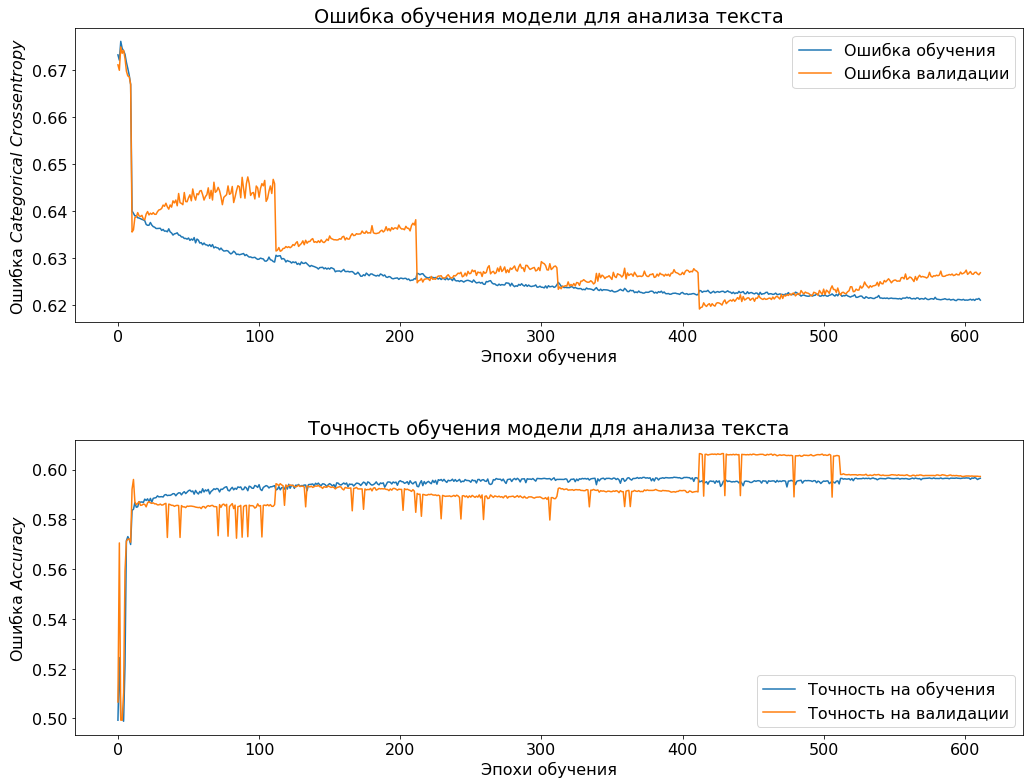

In [32]:
with open('train_history.pickle', 'rb') as f:
    history = pickle.load(f)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 1, figsize=(17,13))

ax[0].plot(history['loss'], label=f"Ошибка обучения")
ax[0].plot(history['val_loss'], label=f"Ошибка валидации")
ax[0].set_xlabel("Эпохи обучения")
ax[0].set_ylabel(r"Ошибка $Categorical$ $Crossentropy$")
ax[0].set_title(f"Ошибка обучения модели для анализа текста")
ax[0].legend(loc="best")

ax[1].plot(history['acc'], label=f"Точность на обучения")
ax[1].plot(history['val_acc'], label=f"Точность на валидации")
ax[1].set_xlabel("Эпохи обучения")
ax[1].set_ylabel(r"Ошибка $Accuracy$")
ax[1].set_title(f"Точность обучения модели для анализа текста")
ax[1].legend(loc="best")

plt.subplots_adjust(hspace=0.4)
plt.savefig("train_info.svg", dpi=200)
plt.show()

## Применение модели

In [14]:
from keras.models import load_model
sentiment_predictor = load_model("sentiment_predictor")

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [15]:
text = [
    u"Самая тупая работа, лучше б и не приходил, ненависть!",
    u"Обожаю вашу компанию, хочу работать только у вас!"
]
new_entry = vectorizator(text, 18)

Максимальная длинна сообщения: 18


In [16]:
predict = sentiment_predictor.predict_classes(new_entry)

In [17]:
prediction_encode = {0: "Негативная окраска", 1: "Позитивная окраска"}
print(f"{text[0]} -- {prediction_encode[predict[0]]}\n{text[1]} -- {prediction_encode[1]}")

Самая тупая работа, лучше б и не приходил, ненависть! -- Негативная окраска
Обожаю вашу компанию, хочу работать только у вас! -- Позитивная окраска


## Подсвечиваем слова для сетки

In [103]:
text = "Сильные способности, на прошлом месте работы надоело, начальник негодяй!"

In [107]:
def predictor_mark_words(model, text: str):
    vec = vectorizator([text], 18)   
    for w in text.split(" "):
        temp_text = ''.join([str(c) + " " for c in text.split(" ") if  c != w])
        vec = np.vstack([vec, vectorizator([temp_text], 18, verbose=False)])
    predict = sentiment_predictor.predict_proba(vec)
    res = np.argmax(a[0])
    marks = predict[1:, res].argsort()[-3:]
    return np.asarray(text.split(" "))[marks]

In [108]:
a = predictor_mark_words(sentiment_predictor, text)

In [109]:
a

array(['начальник', 'негодяй!', 'надоело,'], dtype='<U12')

## Аналитика по тексту

### Грузим базы вакансий по СФО